# 5-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

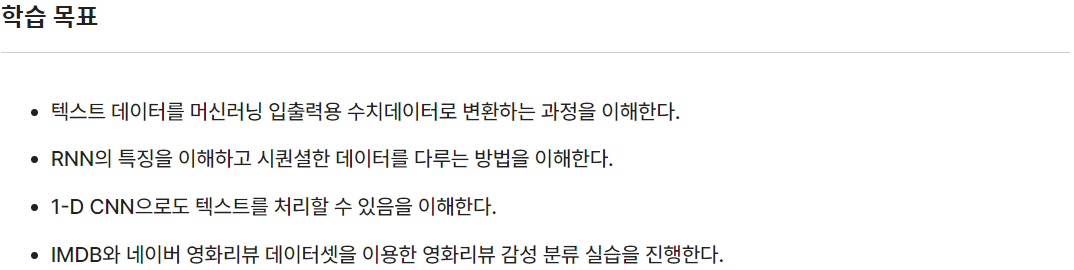

In [1]:
import os, konlpy, gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.initializers import Constant
from keras import callbacks
from collections import Counter
from konlpy.tag import Mecab
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

### 1) 데이터 준비와 확인

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [4]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #데이터의 중복 제거
    train_data = train_data.dropna(how = 'any') #NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)#데이터의 중복 제거
    test_data = test_data.dropna(how = 'any') #NaN 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    print('counter:',len(counter))
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} #사전 word_to_index 구성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=53965)

counter: 53961


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  54
전체 문장의 97.20946661956906%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 54)
(49157, 54)


### 4) 모델 구성 및 validation set 구성 및 모델 훈련 & Loss, Accuracy 그래프 시각화

#### 4-1) 모델 구성

In [10]:
vocab_size = 53965    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5396500   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.3,
                                                  random_state=2023)

In [12]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

check_point_cb_a = callbacks.ModelCheckpoint('_a.keras', save_best_only=True)

early_stopping_cb_a = callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=2048,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[check_point_cb_a, early_stopping_cb_a]
                   )

Epoch 1/100
50/50 [==============================] - 4s 24ms/step - loss: 0.6769 - accuracy: 0.5885 - val_loss: 0.6224 - val_accuracy: 0.7189
Epoch 2/100
50/50 [==============================] - 1s 14ms/step - loss: 0.5033 - accuracy: 0.7750 - val_loss: 0.4474 - val_accuracy: 0.7864
Epoch 3/100
50/50 [==============================] - 1s 14ms/step - loss: 0.3847 - accuracy: 0.8277 - val_loss: 0.4297 - val_accuracy: 0.7944
Epoch 4/100
50/50 [==============================] - 1s 15ms/step - loss: 0.3361 - accuracy: 0.8533 - val_loss: 0.4395 - val_accuracy: 0.7937
Epoch 5/100
50/50 [==============================] - 1s 15ms/step - loss: 0.3000 - accuracy: 0.8699 - val_loss: 0.4551 - val_accuracy: 0.7920
Epoch 6/100
50/50 [==============================] - 1s 14ms/step - loss: 0.2672 - accuracy: 0.8857 - val_loss: 0.4793 - val_accuracy: 0.7890
Epoch 7/100
50/50 [==============================] - 1s 15ms/step - loss: 0.2387 - accuracy: 0.8989 - val_loss: 0.4988 - val_accuracy: 0.7878
Epoch 

In [13]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4364 - accuracy: 0.7901
[0.43644970655441284, 0.7901214361190796]


In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


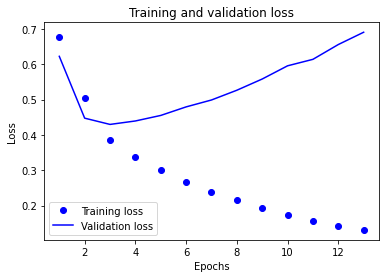

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

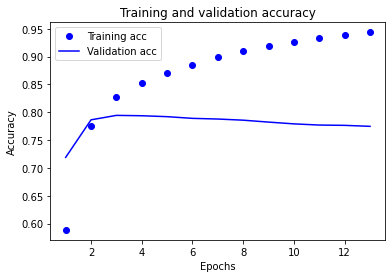

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 4-2) 모델 구성

In [17]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         5396500   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,414,613
Trainable params: 5,414,613
Non-trainable params: 0
_________________________________________________________________


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.3,
                                                  random_state=2023)

In [19]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

check_point_cb_c = callbacks.ModelCheckpoint('_c.keras', save_best_only=True)

early_stopping_cb_c = callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=2048,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[check_point_cb_c, early_stopping_cb_c]
                   )

Epoch 1/100
35/35 [==============================] - 3s 31ms/step - loss: 0.6480 - accuracy: 0.6679 - val_loss: 0.5597 - val_accuracy: 0.7248
Epoch 2/100
35/35 [==============================] - 1s 18ms/step - loss: 0.4516 - accuracy: 0.8230 - val_loss: 0.3912 - val_accuracy: 0.8356
Epoch 3/100
35/35 [==============================] - 1s 18ms/step - loss: 0.3224 - accuracy: 0.8719 - val_loss: 0.3634 - val_accuracy: 0.8415
Epoch 4/100
35/35 [==============================] - 1s 19ms/step - loss: 0.2669 - accuracy: 0.8979 - val_loss: 0.3698 - val_accuracy: 0.8423
Epoch 5/100
35/35 [==============================] - 1s 19ms/step - loss: 0.2331 - accuracy: 0.9149 - val_loss: 0.3880 - val_accuracy: 0.8415
Epoch 6/100
35/35 [==============================] - 1s 19ms/step - loss: 0.2094 - accuracy: 0.9247 - val_loss: 0.4053 - val_accuracy: 0.8386
Epoch 7/100
35/35 [==============================] - 1s 19ms/step - loss: 0.1898 - accuracy: 0.9341 - val_loss: 0.4427 - val_accuracy: 0.8344
Epoch 

In [20]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3669 - accuracy: 0.8391
[0.36693018674850464, 0.8391277194023132]


In [21]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


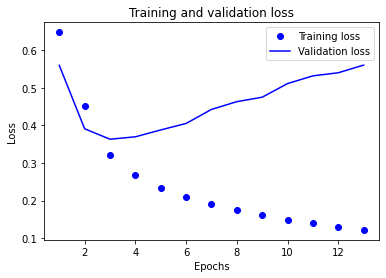

In [22]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

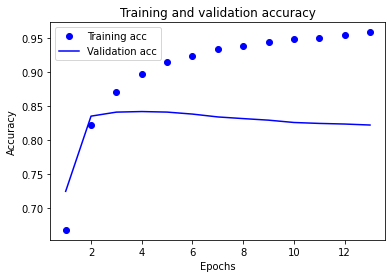

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 4-3) 모델 구성

In [24]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         5396500   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 5,397,317
Trainable params: 5,397,317
Non-trainable params: 0
_________________________________________________________________


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.3,
                                                  random_state=2023)

In [26]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

check_point_cb_b = callbacks.ModelCheckpoint('_b.keras', save_best_only=True)

early_stopping_cb_b = callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=2048,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[check_point_cb_b, early_stopping_cb_b]
                   )

Epoch 1/100
25/25 [==============================] - 1s 16ms/step - loss: 0.6850 - accuracy: 0.5178 - val_loss: 0.6713 - val_accuracy: 0.5611
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 0.6456 - accuracy: 0.6127 - val_loss: 0.6213 - val_accuracy: 0.6672
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 0.5833 - accuracy: 0.7303 - val_loss: 0.5692 - val_accuracy: 0.7437
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 0.5266 - accuracy: 0.8052 - val_loss: 0.5338 - val_accuracy: 0.7841
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 0.4832 - accuracy: 0.8533 - val_loss: 0.5129 - val_accuracy: 0.8034
Epoch 6/100
25/25 [==============================] - 0s 9ms/step - loss: 0.4484 - accuracy: 0.8822 - val_loss: 0.5010 - val_accuracy: 0.8151
Epoch 7/100
25/25 [==============================] - 0s 9ms/step - loss: 0.4200 - accuracy: 0.9039 - val_loss: 0.4956 - val_accuracy: 0.8186
Epoch 8/1

In [27]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4883 - accuracy: 0.8257
[0.4883405566215515, 0.8257420063018799]


In [28]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


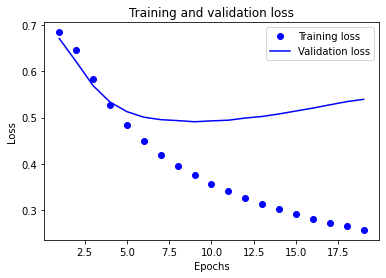

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

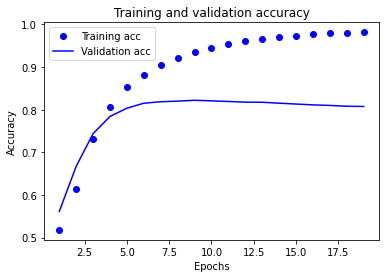

In [30]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5) 학습된 Embedding 레이어 분석

In [31]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(53965, 100)


In [32]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['ㅋㅋ']
vector

array([-0.04435446, -0.07106626, -0.01875832, -0.02199539, -0.01041152,
       -0.05088176, -0.08250418, -0.04131091, -0.05630371, -0.02463332,
        0.01364711, -0.03421009, -0.04242406, -0.04918936,  0.07191978,
       -0.04198881, -0.03642691, -0.02733668,  0.00146556,  0.02507093,
        0.08678462, -0.01381884, -0.05391111, -0.02551652, -0.05675315,
       -0.03241732, -0.03643489, -0.00961657,  0.02804508, -0.03199592,
       -0.05507993, -0.05481386, -0.02236355, -0.04978584, -0.04665906,
        0.01372031, -0.03436426, -0.06276903, -0.04774   , -0.02205024,
       -0.0311781 , -0.03295081, -0.02807875, -0.05126805, -0.05216197,
        0.01770108,  0.10872465, -0.03470448,  0.10180581, -0.01867044,
       -0.03305887,  0.10440028, -0.04857041, -0.03592862, -0.01730251,
       -0.04758667, -0.03513116, -0.03518901, -0.06129902, -0.03571561,
       -0.03898495,  0.01908901, -0.04085444, -0.02764569, -0.01532921,
       -0.04537128, -0.02079041, -0.03182005, -0.04662579, -0.08

In [34]:
word_vectors.similar_by_word("아니")

[('작가', 0.5174126029014587),
 ('잠', 0.5158650279045105),
 ('초반', 0.4851670265197754),
 ('휴', 0.4840778112411499),
 ('배경', 0.47683247923851013),
 ('223423434324434', 0.459506630897522),
 ('왜', 0.4567318260669708),
 ('라길래', 0.44957026839256287),
 ('공산주의', 0.44821897149086),
 ('그러', 0.44028785824775696)]

##### 아니 작가(가 어쩌구저쩌구), 아니 잠(깐만), 아니 초반(에는 어쩌구저쩌구), 휴 아니( 어쩌구저쩌구), 아니 배경(이 어쩌구저쩌구), 아니 왜 ( 어쩌구저쩌구), 아니(라길래), 아니 공산주의(?), 아니 그러(면 어쩌구저쩌구)

##### 한국인의 말버릇 아니를 분석해봤는데 배경과 왜 사이에 있는 '223423434324434'은 왜 나온 건 지 모르겠다. 어느정도 '아니 ~' 하면서 말하는 게 관련이 있게 나온 것 같다.

### 6) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [35]:
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [36]:
word_vectors.wv.similar_by_word("아니")

[('오로지', 0.6562415361404419),
 ('오직', 0.629123330116272),
 ('믿', 0.5989415645599365),
 ('순전히', 0.5725270509719849),
 ('없', 0.5699899196624756),
 ('할지라도', 0.565227210521698),
 ('단순히', 0.5642708539962769),
 ('물론', 0.5641003847122192),
 ('불리', 0.5548262596130371),
 ('아닌', 0.5507720112800598)]

##### 아니 오로지, 아니 오직, 아니 믿(을 수가 없다), 아니 순전히, 아니 없(을 걸?), 아니(할지라도), 아니 단순히, 아니 물론, 아니 불리(하잖아), 아니 아닌(건 아닌 거지)

##### 한국어 임베딩 벡터들은 아니와 관련해서 같이 등장한 단어들이 많이 나온 것 같다.

In [44]:
word_vectors.wv.similar_by_word("재미")

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

##### 하지만 재미라는 단어의 비슷한 뉘앙스의 단어는 잘 파악한 듯 하다.

In [37]:
vocab_size = 53965    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [38]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                    word_vector_dim,
                                    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                    input_length=maxlen,
                                    trainable=True,
                                    mask_zero=True
                                   )
         )   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 54, 100)           5396500   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,430,613
Trainable params: 5,430,613
Non-trainable params: 0
_________________________________________________________________


### layers.Bidirectional: Recurrent layer의 한 종류

In [39]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# BATCH_SIZE = 64
# steps_per_epoch = len(y_train) // BATCH_SIZE

# validation_batch_size = 128
# validation_steps = len(y_val) // validation_batch_size

# 학습의 진행
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

check_point_cb_d = callbacks.ModelCheckpoint('_d.keras', save_best_only=True)

early_stopping_cb_d = callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
#                     batch_size=BATCH_SIZE,
#                     steps_per_epoch=steps_per_epoch,
                    validation_data=(X_val, y_val),
#                     validation_batch_size=validation_batch_size,
#                     validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[check_point_cb_d, early_stopping_cb_d]
                   )

Epoch 1/20
1567/1567 [==============================] - 421s 264ms/step - loss: 0.5032 - accuracy: 0.7507 - val_loss: 0.4081 - val_accuracy: 0.8130
Epoch 2/20
1567/1567 [==============================] - 411s 262ms/step - loss: 0.3868 - accuracy: 0.8298 - val_loss: 0.3777 - val_accuracy: 0.8288
Epoch 3/20
1567/1567 [==============================] - 410s 262ms/step - loss: 0.3421 - accuracy: 0.8535 - val_loss: 0.3586 - val_accuracy: 0.8402
Epoch 4/20
1567/1567 [==============================] - 411s 262ms/step - loss: 0.3145 - accuracy: 0.8684 - val_loss: 0.3509 - val_accuracy: 0.8454
Epoch 5/20
1567/1567 [==============================] - 410s 261ms/step - loss: 0.2906 - accuracy: 0.8802 - val_loss: 0.3488 - val_accuracy: 0.8472
Epoch 6/20
1567/1567 [==============================] - 408s 260ms/step - loss: 0.2704 - accuracy: 0.8903 - val_loss: 0.3488 - val_accuracy: 0.8473
Epoch 7/20
1567/1567 [==============================] - 411s 263ms/step - loss: 0.2533 - accuracy: 0.8999 - val_

In [40]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 43s - loss: 0.3509 - accuracy: 0.8507
[0.35085439682006836, 0.8507435321807861]


In [41]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


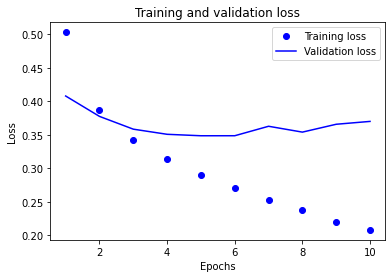

In [42]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

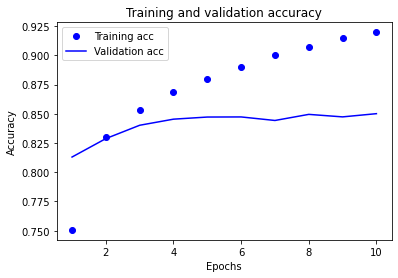

In [43]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

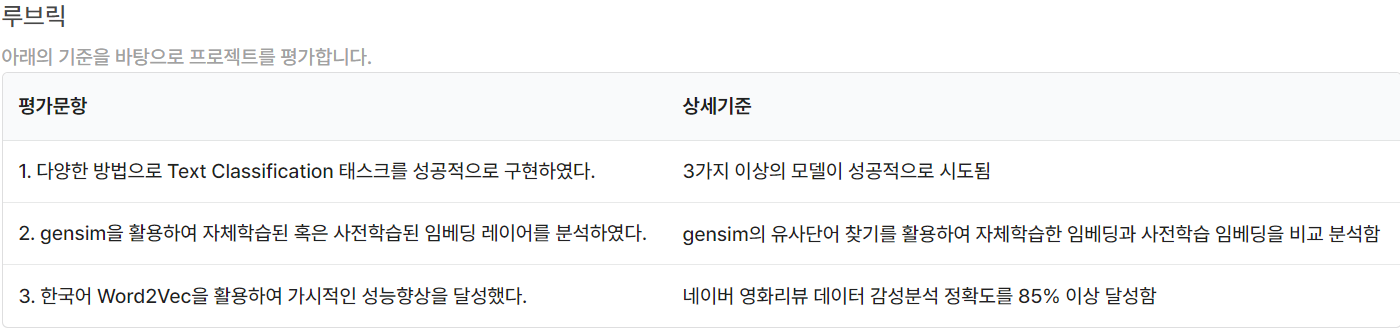

### 9) 회고  

#### 어려웠던 점, 해결을 위해 시도한 방법, 문제해결에 성공한 이유 또는 실패한 이유
    :pre-trained model의 vector_size를 변경해서 불러오고 싶었는데, 하면 안되는 일이었고 불가능한 일이었다. 사전학습 모델을 사용하는 의미가 없다. 불러온 모델로 사용할 거면 어떤 input으로 학습을 해서 어떤 좋은 output이 나왔는지를 확인하고 해야한다. 그리고 Word2Vec은 업데이트가 될 때마다 메소드를 사용하는 방식이 달라지는 편이라서 버전을 잘 확인해야 한다. 계속 맞는 방식으로 vector_size를 변경해서 불러오고 있다고 생각했는데 안 돼서 힘들었다. 이렇게 하면 안된다는 걸 잘 기억해야겠다.
    
#### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    :batch_size와 optimizer를 아무리 바꾼다고 해도 모델 구조 자체에 문제가 있으면 성능은 전혀 나아질 수 없다는 것을 알았다.
    
#### 루브릭 평가 지표를 맞추기 위해 시도한 내용
    :85%를 넘기기 위해서 사전 학습 모델을 사용했는데 전혀 80퍼를 넘지 못해서 답답한 마음에 케창딥을 열어서 텍스트 딥러닝 부분의 모델을 따라했더니 갑자기 85%를 넘었다. 이래서 미리 어떤 모델을 사용해서 어떤 좋은 결과가 나왔는지 논문을 자주 봐줘야 하는 이유가 있는 것 같다. 역시 시간이 걸리더라도 직접 모험을 하는 것 보단 미리 남들이 해놓은 부분을 따라하는 게 훨씬 좋다는 것을 깨달았다.
    
#### 자기 다짐, 프로젝트를 진행하면서 느낀점
    :귀찮더라도 검색을 해서 남들이 어떻게 잘 해냈는지 확인해야겠다. 나 혼자 대충 하려고 하니까 성능이 높아지는 데 걸리는 시간이 너무 오래 걸렸다.빨리 하고 싶었는데 오히려 오래 걸렸다.